
## Acknowledgements
Special thanks to ChatGPT for providing code snippets and guidance for the implementation of various techniques in this project. 
[OpenAI’s ChatGPT](https://www.openai.com/chatgpt) was instrumental in generating code and answering questions about data analysis and 
visualization.


In [25]:
import numpy as np
import pandas as pd
import os
import warnings
import librosa
#import parselmouth
#from parselmouth.praat import call
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
#from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram
import IPython.display as Ipd

import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
import args
from dataset import *
from models import *
from fairness_metrics import *

warnings.filterwarnings("ignore", category=UserWarning, message="PySoundFile failed. Trying audioread instead.")
warnings.filterwarnings("ignore", category=FutureWarning, message="librosa.core.audio.__audioread_load")


# Preparing the dataset

In [34]:

from train_specgram import train_epoch

def visulize_metrics_NN(model_to_test_, best_model_weight_, model, data_dir = './../data/bids_with_sensitive_recordings/',target_diagnosis = 'voc_fold_paralysis'):
    
    dataset = VBAIDataset(data_dir)
    person_session_pairs = get_person_session_pairs(dataset)
    
    model_dir = os.path.join('./..', 'saved_models', model_to_test_)
    test_identities = np.load(os.path.join(model_dir, 'test_ids.npy'))
    
    test_dataset = MyAudioDataset(test_identities, dataset, person_session_pairs,diagnosis_column=target_diagnosis,algo='DL',spec_gram=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    #test_data_labels = np.load(os.path.join(model_dir, 'test_gt_pred.npy'))
    #test_gts = test_data_labels[0]
    #model_preds = test_data_labels[1] 
    # this might not be the predictions from the best models.
    # check the tensorboard logs to find out the best model weights

    train_logs = np.load(os.path.join(model_dir, 'train_logs.npy'))
    val_logs = np.load(os.path.join(model_dir, 'val_logs.npy'))

    # Ensure that train_logs and test_logs have the correct shape
    num_epochs = train_logs.shape[1]
    
    %matplotlib inline
    # Plot train accuracy vs. validation (test) accuracy
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_logs[0], label='Train Accuracy')
    plt.plot(range(num_epochs), val_logs[0], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train Accuracy vs. Validation Accuracy')
    plt.legend()
    
    # Plot train loss vs. test loss
    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_logs[1], label='Train Loss')
    plt.plot(range(num_epochs), val_logs[1], label='Validaiton Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Loss vs. Validatoin Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Test data size : ", len(test_dataset))
    
    test_dataset.set_algorithm_type('DT')
    opensmile_df_test,feature_cols,label_cols = create_open_smile_df(test_dataset,include_GAS=True,diagnosis_column=target_diagnosis)
    test_dataset.set_algorithm_type('DL')

    # load and test the model
    #model = get_models(args=None,spec_gram=spec_gram_)
    model.load_state_dict(torch.load(os.path.join(model_dir, best_model_weight_)))
    binary_crs_entropy_ls = torch.nn.BCELoss(reduction='none')
    
    device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
    model = model.to(device)
    
    model.eval()
    with torch.no_grad():
        test_ls,test_acc,model_preds,ground_truths = train_epoch(model = model, epoch = 0, mode = "Test", data_loader = test_loader, device = device,
                                                                 loss_func = binary_crs_entropy_ls, optimizer = None, scheduler = None, writer = None)
    
    # print/plot metrics
    _, _, _print_string_ = chi_DIR_plot(test_dataset,opensmile_df_test,ground_truths,model_preds,attribute='gender',writer=None,calc_chi_square=False)
    print(_print_string_)
    print()
    equalized_metrics(opensmile_df_test,ground_truths,model_preds,attribute='gender',writer=None)
    
    _, _, _print_string_ = chi_DIR_plot(test_dataset,opensmile_df_test,ground_truths,model_preds,attribute='site',writer=None)
    print(_print_string_)
    print()
    equalized_metrics(opensmile_df_test,ground_truths,model_preds,attribute='site',writer=None)
    
    _, _, _print_string_ = chi_DIR_plot(test_dataset,opensmile_df_test,ground_truths,model_preds,attribute='age',writer=None)
    print(_print_string_)
    print()
    equalized_metrics(opensmile_df_test,ground_truths,model_preds,attribute='AGE_bin',writer=None)


# ResNet model pre-trained on Imagenet (trained with Mel-spectrogram features)

## Comments

- We used all the acoustic tasks except for Audio-Check files.
- We used pre-trained ResNet18 (pre-trained on ImageNet) dataset.
- The reason for using ResNet18 is it is popularly used in literature to train on spectrograms.
- Model overfits (train loss gets lower than validation loss or train accuracy goes higher than that of validation) to the train data quickly.
- As it overfits quickly we probably need a simpler model or more data. The model is too complex for the amount of data.
- The spectrograms from each audio were created with 10 percent overlap with each other.
- We tried with different optmiziers and learning rates the behavior was almost always same.
- We trained end to end.
  
## Future works

- Use XAI (Explainable AI) like : [SHAP (SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/) to interpret the model.
- Trying with more overlaps between spectrograms. It would increase the data size. On the otherhand the overlap could be a reason for overfitting.
- We should try with a simpler Convolutional Network or we could try training only the last few layers of the ResNet18 instead of end to end.

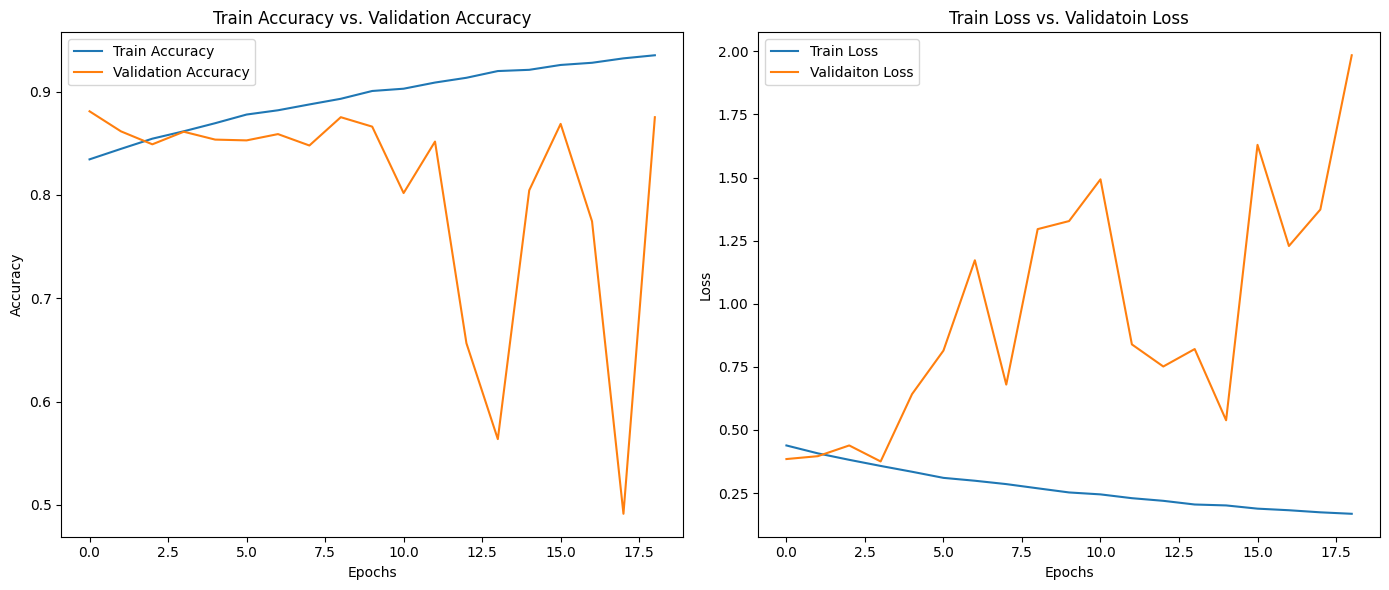

Test data size :  2672


Epoch 0,Test: 100%|█████████████████████████████████| 21/21 [00:08<00:00,  2.36batch/s, Acc=0.85, Lss=0.42]

--- GENDER ---
                         TP   FP     FN      TN  TPR       FPR
Female gender identity  0.0  9.0  141.0  1509.0  0.0  0.005929
Male gender identity    0.0  1.0  263.0   749.0  0.0  0.001333


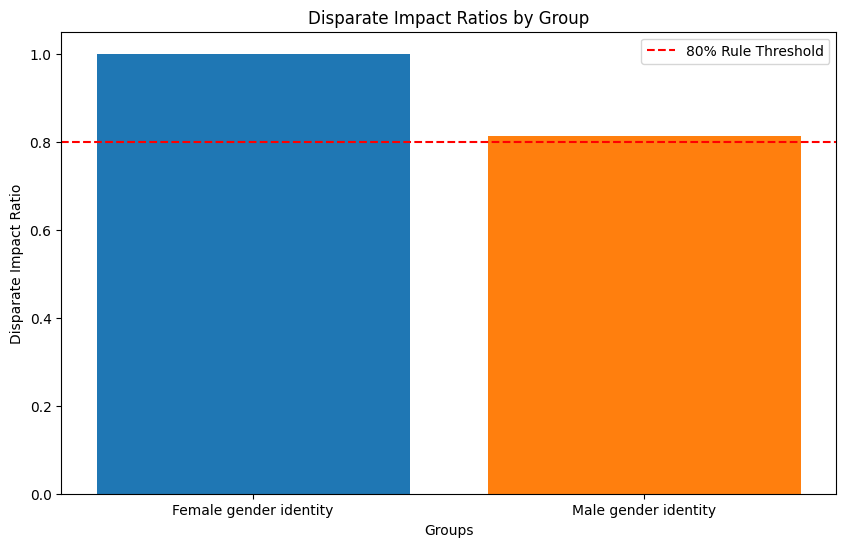

Disparate Impact Ratio for Group Female gender identity: 1.0
Disparate Impact Ratio for Group Male gender identity: 0.8128857653683034


--- GENDER ---
    tp    fp      tn     fn  sens    spec  ppv     npv       j   f1       mcc  \
0  0.0  10.0  2258.0  404.0   0.0  0.9956  0.0  0.8482 -0.0044  0.0 -0.025868   

    brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.1549  0.0  0.0      404.0       10.0     -394.0        -0.9752  

Equalized ODDs

Pre-adjustment group rates are 

 group    fpr  tpr
   0.0 0.0013  0.0
   1.0 0.0059  0.0

And loss is 0.1549


Post-adjustment group rates are 

 group    fpr  tpr
   0.0 0.0013  0.0
   1.0 0.0007  0.0

And loss is 0.1519

Equal Opportunity

Pre-adjustment group rates are 

 group    fpr  tpr
   0.0 0.0013  0.0
   1.0 0.0059  0.0

And loss is 0.1549


Post-adjustment group rates are 

 group    fpr  tpr
   0.0 0.0013  0.0
   1.0 0.0059  0.0

And loss is 0.1549

--- SITE ---
            TP   FP     FN     TN  TPR       FPR

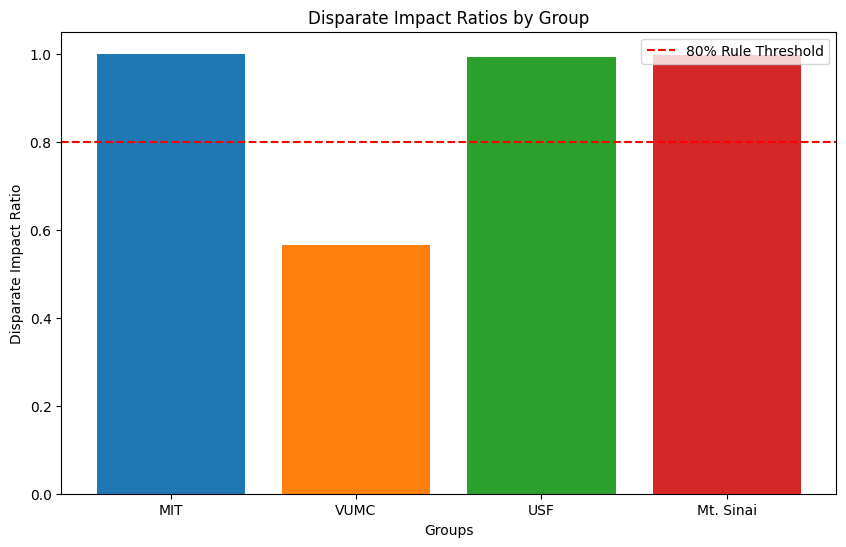

Chi-Square Statistic: nan, p-value: nan
Independent
Disparate Impact Ratio for Group MIT: 1.0
Disparate Impact Ratio for Group VUMC: 0.564937027365676
Disparate Impact Ratio for Group USF: 0.9923885046160971
Disparate Impact Ratio for Group Mt. Sinai: 0.9971650523214608


--- SITE ---
    tp    fp      tn     fn  sens    spec  ppv     npv       j   f1       mcc  \
0  0.0  10.0  2258.0  404.0   0.0  0.9956  0.0  0.8482 -0.0044  0.0 -0.025868   

    brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.1549  0.0  0.0      404.0       10.0     -394.0        -0.9752  

Equalized ODDs

Pre-adjustment group rates are 

 group    fpr  tpr
   0.0 0.0044  NaN
   1.0 0.0019  0.0
   2.0 0.0016  NaN
   3.0 0.0092  NaN

And loss is 0.1549


Post-adjustment group rates are 

 group    fpr  tpr
   0.0 0.0000  NaN
   1.0 0.0019  0.0
   2.0 0.0016  NaN
   3.0 0.0015  NaN

And loss is 0.1523

Equal Opportunity

Pre-adjustment group rates are 

 group    fpr  tpr
   0.0 0.0044  NaN
   1

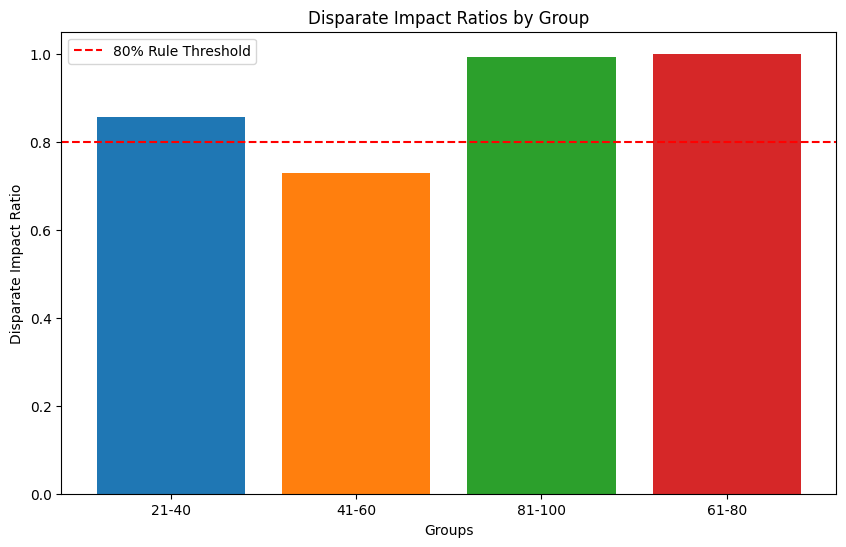

Chi-Square Statistic: nan, p-value: nan
Independent
Disparate Impact Ratio for Group 21-40: 0.8553816411555212
Disparate Impact Ratio for Group 41-60: 0.7295421257084633
Disparate Impact Ratio for Group 81-100: 0.9936856458848231
Disparate Impact Ratio for Group 61-80: 1.0


--- AGE_BIN ---
    tp    fp      tn     fn  sens    spec  ppv     npv       j   f1       mcc  \
0  0.0  10.0  2258.0  404.0   0.0  0.9956  0.0  0.8482 -0.0044  0.0 -0.025868   

    brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.1549  0.0  0.0      404.0       10.0     -394.0        -0.9752  

Equalized ODDs

Pre-adjustment group rates are 

 group    fpr  tpr
   1.0 0.0012  0.0
   2.0 0.0069  0.0
   3.0 0.0026  NaN
   4.0 0.0089  NaN

And loss is 0.1549


Post-adjustment group rates are 

 group    fpr  tpr
   1.0 0.0012  0.0
   2.0 0.0000  0.0
   3.0 0.0000  NaN
   4.0 0.0000  NaN

And loss is 0.1516

Equal Opportunity

Pre-adjustment group rates are 

 group    fpr  tpr
   1.0 0.0012  0.

In [33]:

model_to_test = 'test_resnet18'
best_model_weight = 'best_model_epoch_3.pth'
from torchvision.models import resnet18
model = resnet18("IMAGENET1K_V1")
model.fc = nn.Linear(512*1*1, 1)
visulize_metrics_NN(model_to_test, best_model_weight,model)